In [1]:
import numpy as np
import torch

import sys
sys.path.insert(0, '../01_code')

from simple_Hamiltonian_systems import HarmonicOscillator
from main_simple_Hamiltonian_systems import plot_Ham_sys

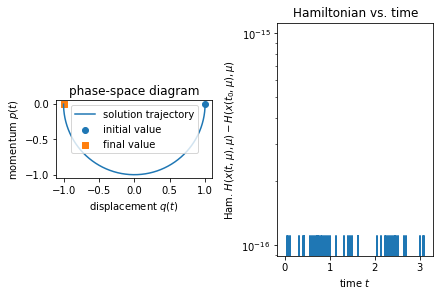

In [2]:
## Harmonic oscillator
model = HarmonicOscillator()
mu = {'m': 1., 'k': 1., 'f': 0., 'q0': 1., 'p0': 0.}
# compute solution for all t in [0, pi]
X, t = model.solve(0, np.pi, np.pi/1e3, mu)
all_Ham = model.Ham(X, mu)
# plot solution
plot_Ham_sys(X, t, all_Ham)

In [3]:
n = 1000 # number of training points
dt = 1e-3

# generate random phase points in [-1,1]x[-1,1]
X_train = np.random.uniform(-1, 1, size=(n,2))

def time_step(x_train):
    # compute one time step h
    mu = {'m': 1., 'k': 1., 'f': 0., 'q0': x_train[0], 'p0': x_train[1]}
    print(mu)
    y_train, _ = model.solve(0, dt, dt, mu)
    print(y_train)

    y_train = np.reshape(y_train, (2,))
    return y_train

Y_train = np.apply_along_axis(time_step, 1, X_train)

print(X_train)
print(Y_train)

# convert to `torch.tensor`
torch.set_default_dtype(torch.float64)
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)

1.0, 'k': 1.0, 'f': 0.0, 'q0': 0.5673212290765834, 'p0': -0.03356489782351879}
[[0.56732123]
 [0.0335649 ]]
{'m': 1.0, 'k': 1.0, 'f': 0.0, 'q0': 0.045769853332489285, 'p0': -0.5927867527170831}
[[0.04576985]
 [0.59278675]]
{'m': 1.0, 'k': 1.0, 'f': 0.0, 'q0': -0.0727355717425604, 'p0': 0.8300778948707623}
[[-0.07273557]
 [-0.83007789]]
{'m': 1.0, 'k': 1.0, 'f': 0.0, 'q0': -0.4482881853188907, 'p0': 0.9076561856092642}
[[-0.44828819]
 [-0.90765619]]
{'m': 1.0, 'k': 1.0, 'f': 0.0, 'q0': -0.07695468226274182, 'p0': 0.020750597122566994}
[[-0.07695468]
 [-0.0207506 ]]
{'m': 1.0, 'k': 1.0, 'f': 0.0, 'q0': 0.6682203529564446, 'p0': -0.7726802928073051}
[[0.66822035]
 [0.77268029]]
{'m': 1.0, 'k': 1.0, 'f': 0.0, 'q0': -0.8582358840187494, 'p0': 0.15179694937509636}
[[-0.85823588]
 [-0.15179695]]
{'m': 1.0, 'k': 1.0, 'f': 0.0, 'q0': -0.12516813579336716, 'p0': 0.08878449625465246}
[[-0.12516814]
 [-0.0887845 ]]
{'m': 1.0, 'k': 1.0, 'f': 0.0, 'q0': -0.47267524392702187, 'p0': -0.471348888596085

In [4]:
# train basic FNN

nn_model = torch.nn.Sequential(
    torch.nn.Linear(2, 50),
    torch.nn.Sigmoid(),
    torch.nn.Linear(50, 50),
    torch.nn.Sigmoid(),
    torch.nn.Linear(50, 2)
)

loss_fn = torch.nn.MSELoss()

learning_rate = 1e-1

for t in range(1000):
    Y_pred = nn_model(X_train)

    loss = loss_fn(Y_pred, Y_train)

    # Zero the gradients before running the backward pass.
    nn_model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model.
    loss.backward()

    # Update the weights using gradient descent.
    with torch.no_grad():
        for param in nn_model.parameters():
            param.data -= learning_rate * param.grad

In [5]:
q0 = 1
p0 = 0.

t_curr = 0.
t_end = np.pi

q_curr = q0
p_curr = p0
X = np.array([[q_curr, p_curr]])

while t_curr < t_end:
    y = nn_model(torch.tensor([[q_curr, p_curr]]))
    q_curr = y.data[0][0].item()
    p_curr = y.data[0][1].item()

    X = np.append(X, np.array([[q_curr, p_curr]]), axis=0)

    t_curr += dt

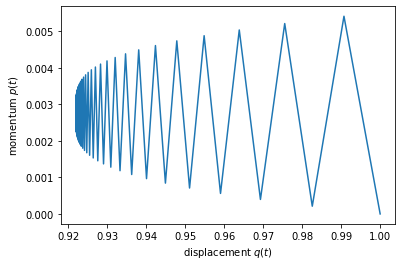

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

ax.plot(X[:,0], X[:,1])
ax.set_xlabel(r'displacement $q(t)$')
ax.set_ylabel(r'momentum $p(t)$')

fig.show()

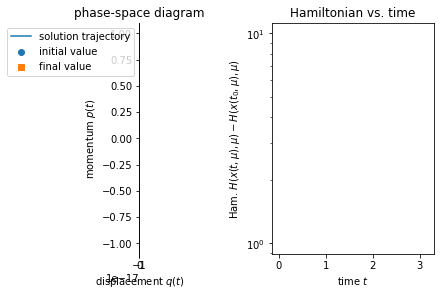

max q value: 0.0
[[ 0.          0.          0.         ... -0.         -0.
  -0.        ]
 [ 1.          0.99999507  0.99998026 ... -0.99995559 -0.99998026
  -0.99999507]]


In [7]:
# TODO Is there a bug inside HarmonicOscillator for some initial values? For example try q0=0 and p0=-1:

## Harmonic oscillator
model = HarmonicOscillator()
mu = {'m': 1., 'k': 1., 'f': 0., 'q0': 0, 'p0': -1}
# compute solution for all t in [0, pi]
X, t = model.solve(0, np.pi, np.pi/1e3, mu)
all_Ham = model.Ham(X, mu)
# plot solution
plot_Ham_sys(X, t, all_Ham)

print('max q value: {}'.format(np.max(np.abs(X[0,:]))))
print(X)